In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import time

In [2]:
GRAVITY = -3.711
def next_state(
   x: float,
   y: float,
   h_speed: float,
   v_speed: float,
   fuel: int,
   angle: int,
   power: int,
   new_angle: int,
   new_power: int
) -> tuple:
   assert new_power <= 1 and new_power >= -1, f"Wrong new_power -> {new_power}"
   power += new_power
   power = max(0, power)
   power = min(4, power)
   assert power in np.arange(0,5), f"Wrong power -> {power}"
   fuel -= power
   assert new_angle <= 15 and new_angle >= -15, f"Wrong new_angle -> {new_angle}"
   angle += new_angle
   angle = max(-90, angle)
   angle = min(90, angle)
   assert new_angle <= 90 and new_angle >= -90, f"Wrong angle -> {angle}"

   radians = (angle * math.pi) / 180.0
   a_h = -math.sin(radians) * power  # horizontal acceleration
   a_v = math.cos(radians) * power + GRAVITY # vertical acceleration

   x += h_speed + a_h / 2.0 # delta x
   y += v_speed + a_v / 2.0 # delta y 

   h_speed += a_h
   v_speed += a_v
   return x, y, h_speed, v_speed, fuel, angle, power

#print(next_state(x=2500, y=2700, h_speed=0, v_speed=0, fuel=5501, angle=0, power=0, new_angle=-15, new_power=1))


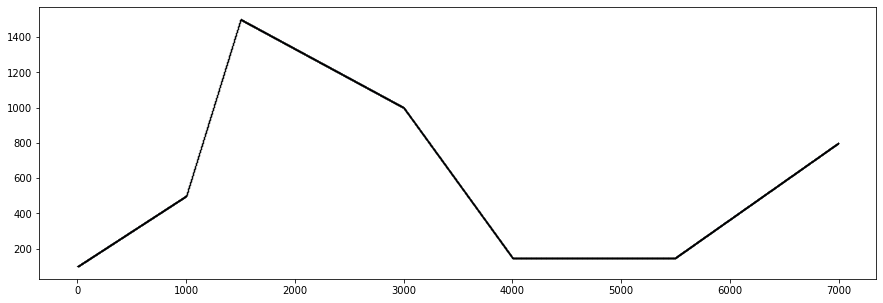

In [3]:
def get_function_params(x1, y1, x2, y2):
   a = (y1 - y2) / (x1 - x2)
   b = y1 - a * x1
   return a, b

def create_map_points(input_surface):
   result_map = {}
   for i in range(len(input_surface)-1):
      x,y = input_surface[i]
      x2,y2 = input_surface[i+1]
      a,b = get_function_params(x,y,x2,y2)
      for x_i in range(x, x2+1):
         result_map[x_i] = a * x_i + b
   return result_map


MAP1 = [(0, 100), (1000, 500), (1500, 1500), (3000, 1000),
        (4000, 150), (5500, 150), (6999, 800)]

map_points = create_map_points(MAP1)

plt.figure(figsize=(15, 5))
plt.scatter(map_points.keys(), map_points.values(), edgecolors='black', s=0.1)


In [4]:
def determine_dist_reward(lx1, lx2, ly, x, y, x_start, y_start):
    dist_x = 0
    dist_y = 0
    middle = (lx2 + lx1) / 2
    dist_x = abs(middle - x) ** 2
    
    if ly - 1 <= y <= ly + 1:
        dist_y = 0    
    else:
        dist_y = (y - ly) ** 2
    
    dist = np.sqrt(dist_x + dist_y)

    return -dist
    

def determine_angle_reward(angle):
    if angle == 0:
        return 200
    return ((90-abs(angle))/90)*100

def intersection(x, y, map):
    return y < map[int(x)]

def find_landing(map_input):
    for i in range(len(map_input) - 1):
        if map_input[i][1] == map_input[i + 1][1] and abs(map_input[i][0] - map_input[i + 1][0]) >= 1000:
            return map_input[i][0], map_input[i + 1][0], map_input[i + 1][1]


In [5]:
def simulate_run(
      actions,
      x=2500,
      y=2700,
      map=map_points,
      h_speed=0,
      v_speed=0,
      fuel=5501,
      angle=0,
      power=0,
      landing_x1=4000,
      landing_x2=5500,
      landing_y=150
   ):
   x_start, y_start = x, y

   crash = False
   path = [(x, y)]
   for new_angle, new_power in actions:
      new_angle = int(round(new_angle))
      new_power = int(round(new_power))
      x_new, y_new, h_speed_new, v_speed_new, fuel_new, angle_new, power_new = next_state(x,y,h_speed, v_speed, fuel, angle, power, new_angle, new_power)
      if fuel <= 0 or x_new < 0 or y_new < 0 or x_new >= 7000 or y_new >= 2800 or intersection(x_new, y_new, map):
         path.append((x_new, y_new))
         crash = True
         break

      x, y, h_speed, v_speed, fuel, angle, power = x_new, y_new, h_speed_new, v_speed_new, fuel_new, angle_new, power_new
      path.append((x, y))

   distance_reward = determine_dist_reward(landing_x1, landing_x2, landing_y, x, y, x_start, y_start)
   angle_reward = determine_angle_reward(angle)
   if abs(v_speed) <= 40:
      v_speed_reward = 1000
   else:
      crash = True
      v_speed_reward = 0
   
   if abs(h_speed) <= 20:
      h_speed_reward = 1000
   else:
      crash = True
      h_speed_reward = 0
   
   total_reward = distance_reward*10 + angle_reward + v_speed_reward + h_speed_reward
   if crash:
      total_reward -= 100000
   return total_reward, path


Performed 2124 simulations in one second.


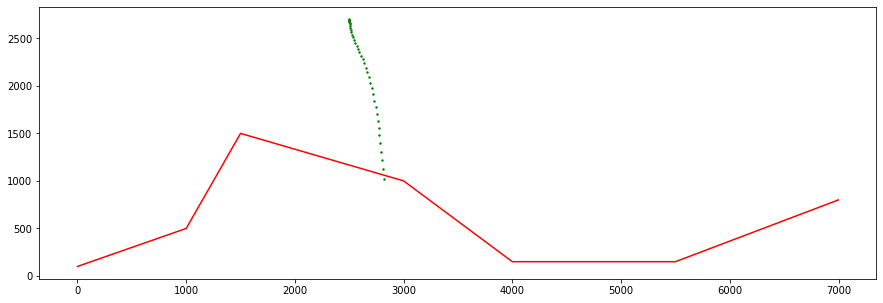

In [7]:
N = 100

start_time = time.time()
simulations = 0
landing_x1, landing_x2, landing_y = find_landing(MAP1)
moves = []
while time.time() - start_time <= 1.0: 
    tmp = np.vstack((
        np.random.randint(-15, 16, N),
        np.random.randint(-1, 2, N)
    )).T

    x_start, y_start = 2500, 2700
    h_speed_start, v_speed_start = 0, 0
    fuel_start, angle_start, power_start = 5501, 0, 0

    score, path = simulate_run(
        actions=tmp,
        x=x_start, 
        y=y_start,
        h_speed=h_speed_start, 
        v_speed=v_speed_start,
        fuel=fuel_start, 
        angle=angle_start, 
        power=power_start,
        map=map_points
    )
    simulations += 1
    moves = tmp

print(f"Performed {simulations} simulations in one second.")

plt.figure(figsize=(15, 5))
xs = [x[0] for x in MAP1]
ys = [x[1] for x in MAP1]
plt.plot(xs, ys, c='red')

for x, y in path:
    plt.scatter(x, y, color='green', s=2)


In [8]:
moves = [tuple(x) for x in moves]
print(moves) # tested on Codin Game -> looked fine :+1:

[(-12, 0), (-5, 1), (8, 1), (-9, -1), (-5, 1), (-8, -1), (-5, 0), (-7, 1), (9, -1), (-1, 1), (4, 1), (7, -1), (-11, 1), (12, 1), (-2, -1), (6, -1), (2, -1), (5, 1), (9, -1), (9, -1), (14, -1), (8, -1), (-4, 0), (6, 0), (4, 1), (0, 1), (3, -1), (8, 1), (13, 0), (-5, -1), (-13, -1), (8, 0), (-3, 0), (-14, -1), (6, 0), (-7, 0), (5, -1), (2, 0), (2, 0), (-6, -1), (11, -1), (12, -1), (0, 1), (14, 0), (-15, -1), (-4, 0), (-14, 1), (13, 1), (-1, -1), (-3, -1), (7, 1), (-11, -1), (3, 1), (-10, -1), (8, 1), (2, -1), (-8, 1), (-7, -1), (12, 0), (-8, 0), (7, 1), (11, -1), (12, 1), (12, -1), (9, 0), (11, 1), (-14, -1), (14, 0), (4, 0), (8, 0), (6, -1), (11, -1), (-11, 0), (1, 1), (10, 1), (13, 1), (4, -1), (14, 0), (6, 1), (-12, -1), (-9, 0), (-13, 0), (-1, -1), (4, -1), (-10, 0), (3, 1), (2, 0), (9, 0), (10, 1), (13, 1), (-3, 1), (-6, 0), (-2, 1), (-7, 0), (14, 1), (-6, -1), (-11, 1), (-6, 0), (-3, 1), (-2, -1)]


In [9]:
class Node:
    def __init__(self, action, parent) -> None:
        self._current_action = action  # pair[int, int]  angle and power
        self._children = {}  # dict[action, Node]
        self._score = -1e18
        self._visited = 0
        self._parent = parent

    def _backpropagate(self, score):
        individual_score = 0
        iters = 0
        while self._parent is not None:
            self._visited += 1
            self._score = max(self._score, score)
            iters += 1
            individual_score += self._score
            self = self._parent
        return individual_score / iters

    def rollout(
        self,
        genotype: np.ndarray,
        x: int, y: int,
        h_speed: int, v_speed: int,
        fuel: int, angle: int, power: int,
        map_points: list,
        landing_x1=4000,
        landing_x2=5500,
        landing_y=150
    ) -> float:
        x_start, y_start = x, y
        crash = False

        # do the actions from previous nodes:

        for new_angle, new_power in actions:
            new_angle = int(round(new_angle))
            new_power = int(round(new_power))
            x2, y2, h_speed2, v_speed2, fuel2, angle2, power2 = next_state(
                x=x, y=y, h_speed=h_speed, v_speed=v_speed, fuel=fuel, angle=angle, power=power,
                new_angle=new_angle, new_power=new_power
            )
            if fuel <= 0 or x2 < 0 or x2 >= 7000 or y2 > 2800 or intersection(x2, y2, map_points):
                if abs(v_speed2) >= 40 or abs(h_speed2) >= 20 or abs(h_speed) >= 20 or abs(v_speed) >= 40 or x2 < landing_x1 or x2 > landing_x2 or angle != 0 or new_angle != 0 or abs(y2 - landing_y) > 1:
                    crash = True
                break
            x, y, h_speed, v_speed, fuel, angle, power = x2, y2, h_speed2, v_speed2, fuel2, angle2, power2

        # rollout new genotype
        next_node = self
        for i, (new_angle, new_power) in enumerate(genotype):
            new_angle = int(round(new_angle))
            new_power = int(round(new_power))
            # assert isinstance(new_angle, np.int64) and isinstance(new_power, np.int64), f"{new_angle} {new_power} {type(new_angle)} {type(new_power)}"
            x2, y2, h_speed2, v_speed2, fuel2, angle2, power2 = next_state(
                x=x, y=y, h_speed=h_speed, v_speed=v_speed, fuel=fuel, angle=angle, power=power,
                new_angle=new_angle, new_power=new_power
            )
            if fuel <= 0 or x2 < 0 or x2 >= 7000 or y2 > 2800 or intersection(x2, y2, map_points):
                if abs(v_speed2) >= 40 or abs(h_speed2) >= 20 or abs(h_speed) >= 20 or abs(v_speed) >= 40 or x2 < landing_x1 or x2 > landing_x2 or angle != 0 or new_angle != 0 or abs(y2 - landing_y) > 1:
                    crash = True
                for j in range(i, len(genotype)):
                    genotype[j] = (0, genotype[j][1])
                break
            x, y, h_speed, v_speed, fuel, angle, power = x2, y2, h_speed2, v_speed2, fuel2, angle2, power2

            new_angle, new_power = int(
                round(new_angle)),  int(round(new_power))

            if (new_angle, new_power) in self._children:
                next_node = self._children[(new_angle, new_power)]
            else:
                self._children[(new_angle, new_power)] = Node(
                    action=(new_angle, new_power), parent=self)
                next_node = self._children[(new_angle, new_power)]

        distance_reward = determine_dist_reward(
            landing_x1, landing_x2, landing_y, x, y, x_start, y_start)
        angle_reward = determine_angle_reward(angle)
        if abs(v_speed) <= 40:
          v_speed_reward = 10000
        else:
          crash = True
          v_speed_reward = 0
       
        if abs(h_speed) <= 20:
          h_speed_reward = 10000
        else:
          crash = True
          h_speed_reward = 0

        score = distance_reward * 5 + angle_reward + v_speed_reward * 4 + h_speed_reward * 2
        if crash:
            score -= 100000

        return next_node._backpropagate(score=score)


In [10]:
actions = []
class RHEA:
    def __init__(self, N, chromosome_len=20, n_mutations=5):
        self._N: int = N
        self._d: int = chromosome_len
        self.n_mutations: int = n_mutations
        self._best_individual = None
        self._best_cost = -1e18
        self._scores = np.ones(N)
        self.node = Node(action=None, parent=None)
        self.cost_history = []  # List[Tuple[min, mean, max]]
        self.best_individuals_history = []
        self.population_angles = np.random.randint(
            low=-15,
            high=16,
            size=(self._N, self._d)
        )
        # 1 - increase thrust | 0 - nothing | -1 - decrease thrust
        self.population_thrust = np.random.randint(
            low=1,
            high=2,
            size=(self._N, self._d)
        )
        self.population = np.stack(
            (self.population_angles, self.population_thrust), axis=2)

    def _parents_selection(self) -> np.ndarray:
        """ Roulette method """
        fitness_values = self._scores.copy()
        fitness_values = fitness_values - fitness_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(
                len(self.population)) / len(self.population)

        ids = np.random.choice(
            np.arange(self._N),
            size=self._N,
            replace=True,
            p=fitness_values
        )
        return ids

    def _replacement_and_crossover(self, ids) -> None:
        self.population = self.population[ids]

        parents_ids = np.arange(self._N)
        np.random.shuffle(parents_ids)

        p1 = self.population[parents_ids[self._N // 2]]
        p2 = self.population[self._N // 2:]

        r = np.random.rand(self._N // 2)[:, np.newaxis, np.newaxis]
        children1 = r * p1 + (1 - r) * p2
        children2 = (1 - r) * p1 + r * p2

        self.population = np.vstack((children1, children2))
        self.population[:, :, 1] = np.round(
            self.population[:, :, 1]).astype(np.int)

    def _mutation(self) -> None:
        random_indices = np.random.randint(
            0, self._d, size=(self.n_mutations, self._N))

        self.population[:, :, 0][np.arange(
            self._N), random_indices] = np.random.uniform(-15, 15, size=self._N)
        self.population[:, :, 1][np.arange(
            self._N), random_indices] = np.random.randint(-1, 2, size=self._N)

    def run(self, x: int, y: int,
                  h_speed: int, v_speed: int,
                  fuel: int, angle: int, power: int,
                  map_points: list,
                  l: int, r: int, h: int):
        start_time = time.time()
        self._best_cost = -1000000000
        while time.time() - start_time < 1: # here we can put the time constraint
            self.population_rollout(x, y, h_speed, v_speed, fuel, angle, power, map_points, l, r, h) #evaluate current population

            best_cost_index = self._scores.argmax()
            best_current_individual = self.population[best_cost_index]
            if self._scores[best_cost_index] > self._best_cost:
                self._best_cost = self._scores[best_cost_index]
                self._best_individual = best_current_individual

            parents_ids = self._parents_selection()
            self._replacement_and_crossover(ids=parents_ids)
            self._mutation()
            self.population[self._scores.argmin(
            )] = best_current_individual

        self.best_individuals_history.append(self._best_individual)
        action = self._best_individual[0]
        actions.append(action)

        if tuple(action) in self.node._children:
                self.node = self.node._children[tuple(action)]
        else:
            self.node._children[tuple(action)] = Node(
                action=tuple(action), parent=self.node)
            self.node = self.node._children[tuple(action)]


        self._best_individual = self._best_individual[1:] # rolling best individual
        self._best_individual = np.stack((np.append(self._best_individual[:, 0],np.random.randint(low=-15, high=16)), np.append(self._best_individual[:, 1], np.random.randint(low=-1, high=2))), axis=1)
        # rolling population
        # self.population = np.delete(self.population, 0, 1)
        # self._best_cost = -1e18
        temp = []
        for arr in self.population:
            t = list(arr)[1:]
            t.append([np.random.randint(low=-15, high=16),
                      np.random.randint(low=-1, high=2)])
            temp.append(t)
        self.population = np.array(temp)
    
    def population_rollout(
        self,
        x: int, y: int,
        h_speed: int, v_speed: int,
        fuel: int, angle: int, power: int,
        map_points: list,
        l: int, r: int, h: int
    ):
        scores = []
        for individual in self.population:
            individual_score = self.node.rollout(
                genotype=individual,
                x=x, y=y,
                h_speed=h_speed, v_speed=v_speed,
                fuel=fuel, angle=angle, power=power,
                map_points=map_points,
                landing_x1=l, landing_x2=r, landing_y=h
            )
            scores.append(individual_score)
        self._scores = np.array(scores)


In [11]:
CHROMOSOME_LEN = 60
actions = []
model = RHEA(N=100, chromosome_len=CHROMOSOME_LEN, n_mutations=2)
for _ in tqdm(range(150), position=0):
    model.run(x=x_start, y=y_start,
                    h_speed=h_speed_start, v_speed=v_speed_start,
                    fuel=fuel_start, angle=angle_start, power=power_start,
                    map_points=map_points,
                    l=4000, r=5500, h=150)


100%|██████████| 150/150 [02:39<00:00,  1.06s/it]


(4785.612343003178, 130.85804734633962)
[(1, 1), (-0.37947559287073673, -1.0), (-6.874702871674245, 0.0), (1.5129822385974228, 0.0), (-2.4409531395662247, 1.0), (-8.197353276267721, 1.0), (-0.14803787143219616, 1.0), (-8.170858778084098, 0.0), (4.067012577083228, 1.0), (-3.644527588962408, 0.0), (-3.0147386684249557, 0.0), (1.3062648341774992, 0.0), (-2.321507442596417, 0.0), (-5.218215669608949, 0.0), (-0.34065898637907926, 0.0), (3.677005809062971, -1.0), (5.787685163675146, 1.0), (1.0258328676365647, 1.0), (9.492232691473045, -1.0), (2.868897045468971, 1.0), (-0.17012030231651262, 0.0), (-1.9419546431956565, 1.0), (-14.706614225278912, 0.0), (-1.407454297846395, 1.0), (-2.6252170547161637, 0.0), (-4.783886402507253, 0.0), (2.457794572067073, 1.0), (0.7527647994993708, 0.0), (5.100684424716893, 0.0), (8.546164986560095, 0.0), (-5.416282673039374, 0.0), (4.943651875836819, 1.0), (-9.577087971642868, 1.0), (-0.20142814231977152, 1.0), (-2.1812040516954903, -1.0), (4.659780601661178, 1.

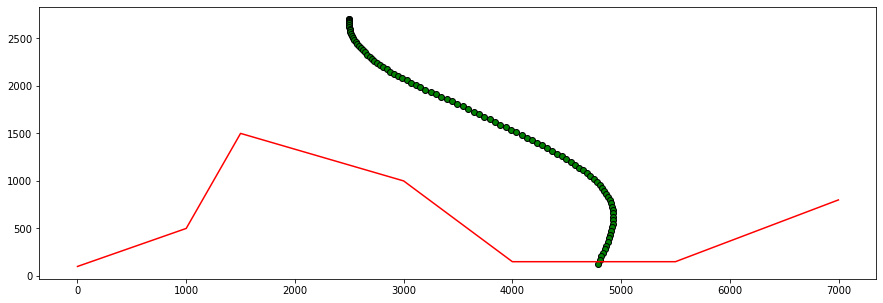

In [12]:
score, cords = simulate_run(
    actions=actions,
    x=x_start, y=y_start,
    h_speed=h_speed_start, v_speed=v_speed_start,
    fuel=fuel_start, angle=angle_start, power=power_start,
    map=map_points,
)

plt.figure(figsize=(15, 5))
plt.plot(xs, ys, c='red')

for x, y in cords:
    plt.scatter(x, y, edgecolors='black', color='green')

print(cords[-1])
print([tuple(x) for x in actions])


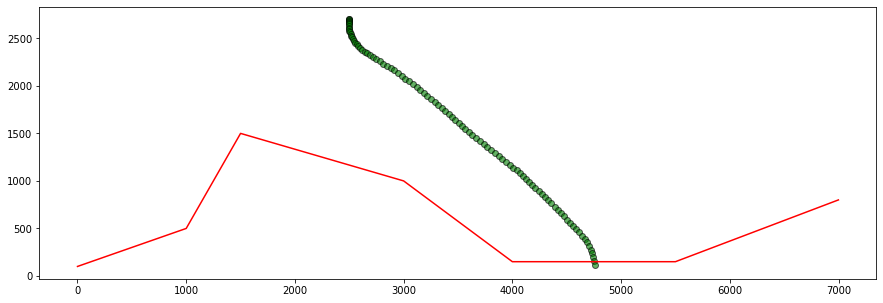

In [44]:
from IPython.display import clear_output

def plot_population(population: np.ndarray):
    plt.figure(figsize=(15, 5))
    xs = [x[0] for x in MAP1]
    ys = [x[1] for x in MAP1]
    plt.plot(xs, ys, c='red')
    score, path = simulate_run(
        actions=population,
        x=x_start, y=y_start,
        h_speed=h_speed_start, v_speed=v_speed_start,
        fuel=fuel_start, angle=angle_start, power=power_start,
        map=map_points,
        landing_x1=landing_x1, landing_x2=landing_x2, landing_y=landing_y
    )
    for x, y in path:
        plt.scatter(x, y, edgecolors='black', color='green', alpha=0.6)
    clear_output(wait=True)
    plt.show()


for i, population in enumerate(model.best_individuals_history):
    print(f'{i + 1} / {len(model.best_individuals_history)}')
    population = list(actions[:i]) + list(population)
    plot_population(population=population)


In [ ]:
MAP2 = [(0, 100), (1000, 500), (1500, 100), (3000, 100), (3500, 500),
        (3700, 200), (5000, 1500), (5800, 300), (6000, 1000), (6999, 2000)]
map_points2 = create_map_points(MAP2)
landing_x1, landing_x2, landing_y = find_landing(MAP2)
x_start, y_start, h_speed_start, v_speed_start, fuel_start, angle_start, power_start = 6500, 2800, -100, 0, 600, 90, 0


In [ ]:
CHROMOSOME_LEN = 70
actions = []
model2 = RHEA(N=500, chromosome_len=CHROMOSOME_LEN, n_mutations=2)
for _ in tqdm(range(150), position=0):
    model.run(x=x_start, y=y_start,
              h_speed=h_speed_start, v_speed=v_speed_start,
              fuel=fuel_start, angle=angle_start, power=power_start,
              map_points=map_points2,
              l=landing_x1, r=landing_x2, h=landing_y)


100%|██████████| 150/150 [12:35<00:00,  5.04s/it]


(2145.270236537674, -4.475659084462976)
[(1.8092617721042439, 0.0), (6.109168333012535, 0.0), (-5.35731582342164, 0.0), (2.284130496399658, -1.0), (7.402764791056472, -1.0), (0.16435226273316417, -1.0), (0.6742229770230708, 1.0), (9.08458117763531, 0.0), (-11.658304525573989, 0.0), (4.7971590482986315, -1.0), (6.878929974135653, 0.0), (1.5100243099202797, 1.0), (3.8774115368111075, -1.0), (-2.3256033662360083, 0.0), (-6.32540879285097, 0.0), (-7.647835920194394, 1.0), (3.8829382057644217, 0.0), (2.024263638729696, 0.0), (0.2309679943232305, -1.0), (-3.7140188802196183, 0.0), (7.53951791051816, 1.0), (-11.474626174412071, 1.0), (1.5790970831548545, -1.0), (4.759839063043589, -1.0), (-11.650048488053901, 0.0), (-6.620374080482114, 1.0), (-3.630580405626502, 1.0), (-11.736506358261861, -1.0), (-8.315136460869347, 0.0), (-2.5544911946779014, 0.0), (-7.770218485005472, 1.0), (8.146597224878795, -1.0), (-7.41132983631467, 0.0), (-3.5918090946980525, 0.0), (4.790520087810876, 1.0), (-13.91005

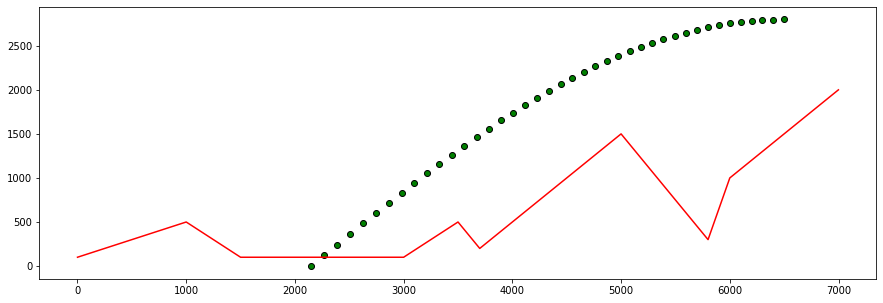

In [ ]:
score, cords = simulate_run(
    actions=actions,
    x=x_start, y=y_start,
    h_speed=h_speed_start, v_speed=v_speed_start,
    fuel=fuel_start, angle=angle_start, power=power_start,
    map=map_points2,
)
xs = [x[0] for x in MAP2]
ys = [x[1] for x in MAP2]
plt.figure(figsize=(15, 5))
plt.plot(xs, ys, c='red')

for x, y in cords:
    plt.scatter(x, y, edgecolors='black', color='green')

print(cords[-1])
print([tuple(x) for x in actions])


In [ ]:
landing_x1, landing_x2, landing_y = find_landing(MAP1)
x_start, y_start, h_speed_start, v_speed_start, fuel_start, angle_start, power_start = 6500, 2800, -90, 0, 750, 90, 0

CHROMOSOME_LEN = 70
actions = []
model2 = RHEA(N=300, chromosome_len=CHROMOSOME_LEN, n_mutations=2)
for _ in tqdm(range(150), position=0):
    model.run(x=x_start, y=y_start,
              h_speed=h_speed_start, v_speed=v_speed_start,
              fuel=fuel_start, angle=angle_start, power=power_start,
              map_points=map_points,
              l=landing_x1, r=landing_x2, h=landing_y)


100%|██████████| 150/150 [12:35<00:00,  5.04s/it]


(3345.3971029587155, 536.4498374861417)
[(9.851324051496768, 0.0), (-7.52066928379546, 0.0), (-0.2459284782615354, 0.0), (-1.5055786717370128, 0.0), (0.6619056683219287, 0.0), (0.3955193101900707, 0.0), (5.805686046341586, 0.0), (-3.2823916137139486, 0.0), (0.7577220995005188, 0.0), (-0.850315484577552, 0.0), (-3.662936150255378, -1.0), (3.3009407768457577, 0.0), (-6.37641295136663, 0.0), (-5.721417461033618, 0.0), (-4.893176152675096, -1.0), (4.18322369967187, 0.0), (-8.478326807703677, -1.0), (2.169638095648249, 0.0), (-7.912448259371629, 0.0), (-0.8511781128203393, 0.0), (-2.32465021815434, 0.0), (-5.890830791994344, -1.0), (-2.388458925954668, 0.0), (-4.237668627686201, 0.0), (-14.998056478961798, 1.0), (1.9442100836466545, -1.0), (3.4865569014815088, 0.0), (-5.075793473537748, 0.0), (-6.484532310948774, -1.0), (-3.544759648188667, 0.0), (-8.982680194678574, 0.0), (1.6407102804894858, 0.0), (-6.092760654481449, 0.0), (-3.1282494280234854, -1.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), 

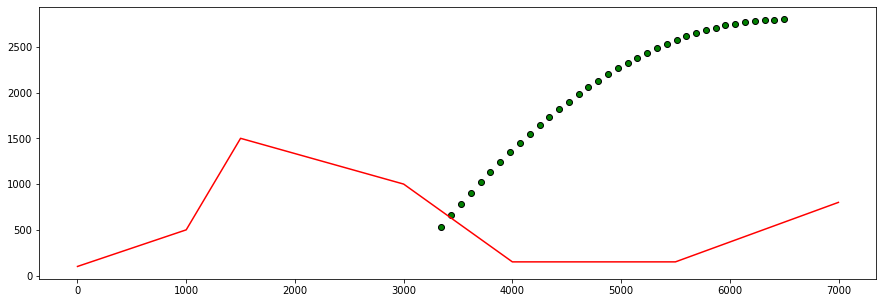

In [ ]:
score, cords = simulate_run(
    actions=actions,
    x=x_start, y=y_start,
    h_speed=h_speed_start, v_speed=v_speed_start,
    fuel=fuel_start, angle=angle_start, power=power_start,
    map=map_points,
)
xs = [x[0] for x in MAP1]
ys = [x[1] for x in MAP1]
plt.figure(figsize=(15, 5))
plt.plot(xs, ys, c='red')

for x, y in cords:
    plt.scatter(x, y, edgecolors='black', color='green')

print(cords[-1])
print([tuple(x) for x in actions])
